In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [14]:
class DDoSVisualization:
    def __init__(self):
        plt.style.use('seaborn')

    def plot_traffic_patterns(self, df, time_column='dt'):
        """Visualize traffic patterns over time."""
        plt.figure(figsize=(15, 10))

        # Create subplots for different metrics
        plt.subplot(2, 2, 1)
        self._plot_metric_over_time(df, time_column, 'pktcount', 'Packet Count Over Time')

        plt.subplot(2, 2, 2)
        self._plot_metric_over_time(df, time_column, 'bytecount', 'Byte Count Over Time')

        plt.subplot(2, 2, 3)
        self._plot_metric_over_time(df, time_column, 'pktrate', 'Packet Rate Over Time')

        plt.subplot(2, 2, 4)
        self._plot_metric_over_time(df, time_column, 'tot_kbps', 'Total Kbps Over Time')

        plt.tight_layout()
        return plt.gcf()

    def _plot_metric_over_time(self, df, time_column, metric, title):
        """Helper function to plot metrics over time."""
        normal = df[df['label'] == 0]
        attack = df[df['label'] == 1]

        plt.plot(normal[time_column], normal[metric], 'b.', alpha=0.5, label='Normal')
        plt.plot(attack[time_column], attack[metric], 'r.', alpha=0.5, label='Attack')
        plt.title(title)
        plt.xticks(rotation=45)
        plt.legend()

    def plot_feature_distributions(self, df, features):
        """Plot distribution of features comparing normal vs attack traffic."""
        n_features = len(features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 5 * n_rows))

        for i, feature in enumerate(features):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.kdeplot(data=df[df['label'] == 0][feature], label='Normal', color='blue')
            sns.kdeplot(data=df[df['label'] == 1][feature], label='Attack', color='red')
            plt.title(f'{feature} Distribution')
            plt.legend()

        plt.tight_layout()
        return plt.gcf()

    def plot_correlation_matrix(self, df, features):
        """Plot correlation matrix of features."""
        plt.figure(figsize=(12, 10))
        correlation_matrix = df[features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        return plt.gcf()

    def plot_model_performance(self, history):
        """Plot DL model training history."""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        return plt.gcf()

    def plot_roc_curves(self, y_true, ml_probs, dl_probs, ensemble_probs):
        """Plot ROC curves for ML, DL, and ensemble models."""
        plt.figure(figsize=(10, 8))

        # Calculate ROC curves
        ml_fpr, ml_tpr, _ = roc_curve(y_true, ml_probs)
        dl_fpr, dl_tpr, _ = roc_curve(y_true, dl_probs)
        ensemble_fpr, ensemble_tpr, _ = roc_curve(y_true, ensemble_probs)

        # Calculate AUC
        ml_auc = auc(ml_fpr, ml_tpr)
        dl_auc = auc(dl_fpr, dl_tpr)
        ensemble_auc = auc(ensemble_fpr, ensemble_tpr)

        # Plot ROC curves
        plt.plot(ml_fpr, ml_tpr, label=f'ML (AUC = {ml_auc:.3f})')
        plt.plot(dl_fpr, dl_tpr, label=f'DL (AUC = {dl_auc:.3f})')
        plt.plot(ensemble_fpr, ensemble_tpr, label=f'Ensemble (AUC = {ensemble_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()

        return plt.gcf()

    def plot_confusion_matrices(self, y_true, ml_pred, dl_pred, ensemble_pred):
        """Plot confusion matrices for all models."""
        plt.figure(figsize=(15, 5))

        # ML model confusion matrix
        plt.subplot(1, 3, 1)
        self._plot_confusion_matrix(y_true, ml_pred, 'ML Model')

        # DL model confusion matrix
        plt.subplot(1, 3, 2)
        self._plot_confusion_matrix(y_true, dl_pred, 'DL Model')

        # Ensemble model confusion matrix
        plt.subplot(1, 3, 3)
        self._plot_confusion_matrix(y_true, ensemble_pred, 'Ensemble Model')

        plt.tight_layout()
        return plt.gcf()

    def _plot_confusion_matrix(self, y_true, y_pred, title):
        """Helper function to plot a single confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

In [15]:
class DDoSDetectionSystem:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.ml_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.dl_model = None

    def clean_data(self, df):
        """Clean the dataset by handling missing values and outliers."""
        df_cleaned = df.copy()

        # Replace infinite values with NaN
        df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Handle missing values for each column type
        numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
        categorical_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns

        # For numeric columns: replace NaN with median
        for col in numeric_columns:
            median_value = df_cleaned[col].median()
            df_cleaned[col].fillna(median_value, inplace=True)

        # For categorical columns: replace NaN with mode
        for col in categorical_columns:
            mode_value = df_cleaned[col].mode()[0]
            df_cleaned[col].fillna(mode_value, inplace=True)

        # Handle outliers using IQR method for numeric columns
        for col in numeric_columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Cap the outliers
            df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)

        return df_cleaned

    def preprocess_ip(self, ip_str):
        """Convert IP address to numerical format with error handling."""
        try:
            if pd.isna(ip_str):
                return 0
            ip = ipaddress.ip_address(str(ip_str))
            return int(ip)
        except:
            return 0

    def preprocess_data(self, df):
        """Preprocess the dataset for ML/DL models with robust error handling."""
        # Clean the data first
        df_cleaned = self.clean_data(df)

        # Create a copy of the cleaned dataframe
        df_processed = df_cleaned.copy()

        # Convert IP addresses to numerical format
        df_processed['src'] = df_processed['src'].apply(self.preprocess_ip)
        df_processed['dst'] = df_processed['dst'].apply(self.preprocess_ip)

        # Convert protocol to numerical if it's categorical
        df_processed['Protocol'] = self.label_encoder.fit_transform(df_processed['Protocol'])

        # Convert label to numerical
        df_processed['label'] = self.label_encoder.fit_transform(df_processed['label'])

        # Select features for training
        feature_columns = ['src', 'dst', 'pktcount', 'bytecount', 'dur', 'dur_nsec',
                         'tot_dur', 'flows', 'packetins', 'pktperflow', 'byteperflow',
                         'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
                         'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps']

        X = df_processed[feature_columns]
        y = df_processed['label']

        # Additional check for NaN values after processing
        if X.isnull().any().any():
            print("Warning: NaN values found after processing. Filling with 0...")
            X = X.fillna(0)

        # Scale the features
        X_scaled = self.scaler.fit_transform(X)

        return X_scaled, y

    def build_dl_model(self, input_shape):
        """Build and compile the deep learning model."""
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),

            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

        self.dl_model = model
        return model

    def train_models(self, X, y, test_size=0.2):
        """Train both ML and DL models."""
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Train ML model (Random Forest)
        print("Training ML model (Random Forest)...")
        self.ml_model.fit(X_train, y_train)
        ml_predictions = self.ml_model.predict(X_test)
        print("\nML Model Performance:")
        print(classification_report(y_test, ml_predictions))

        # Build and train DL model
        print("\nTraining DL model...")
        self.build_dl_model(X_train.shape[1])

        history = self.dl_model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )

        dl_predictions = (self.dl_model.predict(X_test) > 0.5).astype(int)
        print("\nDL Model Performance:")
        print(classification_report(y_test, dl_predictions))

        return X_test, y_test

    def predict(self, X, ensemble=True):
        """Make predictions using trained models."""
        if ensemble:
            # Combine predictions from both models
            ml_pred = self.ml_model.predict_proba(X)[:, 1]
            dl_pred = self.dl_model.predict(X).flatten()

            # Average the predictions
            ensemble_pred = (ml_pred + dl_pred) / 2
            return (ensemble_pred > 0.5).astype(int)
        else:
            # Use only ML model for faster prediction
            return self.ml_model.predict(X)

    def update_model(self, X_new, y_new):
        """Update models with new data (incremental learning)."""
        # Update ML model (Random Forest doesn't support true incremental learning,
        # so we'll retrain on new data)
        self.ml_model.fit(X_new, y_new)

        # Update DL model
        self.dl_model.fit(
            X_new, y_new,
            epochs=10,
            batch_size=32,
            verbose=0
        )

    def visualize_results(self, X_test, y_test, history=None):
        """Generate comprehensive visualizations of model performance."""
        viz = DDoSVisualization()

        # Get predictions from all models
        ml_probs = self.ml_model.predict_proba(X_test)[:, 1]
        dl_probs = self.dl_model.predict(X_test).flatten()
        ensemble_probs = (ml_probs + dl_probs) / 2

        # Get binary predictions
        ml_pred = (ml_probs > 0.5).astype(int)
        dl_pred = (dl_probs > 0.5).astype(int)
        ensemble_pred = (ensemble_probs > 0.5).astype(int)

        # Generate visualizations
        plots = {
            'roc_curves': viz.plot_roc_curves(y_test, ml_probs, dl_probs, ensemble_probs),
            'confusion_matrices': viz.plot_confusion_matrices(y_test, ml_pred, dl_pred, ensemble_pred)
        }

        if history:
            plots['training_history'] = viz.plot_model_performance(history)

        return plots

In [16]:
class RealTimeDetector:
    def __init__(self, detection_system):
        self.detection_system = detection_system
        self.alert_threshold = 0.8

    def process_traffic(self, traffic_data):
        """Process incoming traffic data in real-time."""
        # Preprocess the traffic data
        X, _ = self.detection_system.preprocess_data(traffic_data)

        # Make prediction
        prediction = self.detection_system.predict(X, ensemble=True)

        # Calculate confidence score
        ml_confidence = self.detection_system.ml_model.predict_proba(X)[:, 1]
        dl_confidence = self.detection_system.dl_model.predict(X).flatten()
        confidence = (ml_confidence + dl_confidence) / 2

        return {
            'is_attack': bool(prediction[0]),
            'confidence': float(confidence[0]),
            'alert': bool(confidence[0] > self.alert_threshold)
        }

    def visualize_traffic(self, traffic_data):
        """Visualize real-time traffic patterns."""
        viz = DDoSVisualization()
        return viz.plot_traffic_patterns(traffic_data)


In [17]:
def main():
    # Load your dataset

    # Initialize the detection system
    ddos_system = DDoSDetectionSystem()

    df = pd.read_csv('dataset_sdn.csv')

    # Add some random NaN values
    for col in df.columns:
        mask = np.random.random(len(df)) < 0.05  # 5% NaN values
        df.loc[mask, col] = np.nan

    print("Initial data shape:", df.shape)
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())

    # Preprocess and train models
    X, y = ddos_system.preprocess_data(df)
    X_test, y_test = ddos_system.train_models(X, y)

    # Initialize real-time detector
    detector = RealTimeDetector(ddos_system)

    # Simulate real-time traffic detection
    result = detector.process_traffic(df.iloc[[0]])
    print("\nReal-time Detection Result:", result)

    # Create visualizations
    viz = DDoSVisualization()

    # Plot traffic patterns
    traffic_viz = viz.plot_traffic_patterns(df)
    traffic_viz.savefig('traffic_patterns.png')

    # Plot feature distributions
    feature_viz = viz.plot_feature_distributions(df,
        ['pktcount', 'bytecount', 'pktrate', 'tot_kbps', 'flows', 'pktperflow'])
    feature_viz.savefig('feature_distributions.png')

    # Plot correlation matrix
    corr_viz = viz.plot_correlation_matrix(df,
        ['pktcount', 'bytecount', 'pktrate', 'tot_kbps', 'flows', 'pktperflow'])
    corr_viz.savefig('correlation_matrix.png')

    # Generate model performance visualizations
    performance_plots = ddos_system.visualize_results(X_test, y_test)
    for name, plot in performance_plots.items():
        plot.savefig(f'{name}.png')

    print("Visualizations have been saved to files.")


Initial data shape: (104345, 23)

Missing values before cleaning:
dt             5174
switch         5244
src            5241
dst            5158
pktcount       5242
bytecount      5109
dur            5236
dur_nsec       5249
tot_dur        5246
flows          5224
packetins      5140
pktperflow     5152
byteperflow    5197
pktrate        5261
Pairflow       5224
Protocol       5271
port_no        5234
tx_bytes       5233
rx_bytes       5112
tx_kbps        5129
rx_kbps        5746
tot_kbps       5845
label          5213
dtype: int64


<ipython-input-15-02e14546a31d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_value, inplace=True)
<ipython-input-15-02e14546a31d>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Training ML model (Random Forest)...

ML Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     13131
           1       0.95      1.00      0.97      7738

    accuracy                           0.98     20869
   macro avg       0.97      0.98      0.98     20869
weighted avg       0.98      0.98      0.98     20869


Training DL model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8274 - loss: 0.3721 - val_accuracy: 0.9357 - val_loss: 0.1778
Epoch 2/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9199 - loss: 0.2139 - val_accuracy: 0.9474 - val_loss: 0.1542
Epoch 3/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9299 - loss: 0.1894 - val_accuracy: 0.9510 - val_loss: 0.1436
Epoch 4/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9372 - loss: 0.1765 - val_accuracy: 0.9512 - val_loss: 0.1441
Epoch 5/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9406 - loss: 0.1687 - val_accuracy: 0.9554 - val_loss: 0.1371
Epoch 6/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9440 - loss: 0.1613 - val_accuracy: 0.9560 - val_loss: 0.1345
Epoch 7/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9460 - loss: 0.1609 - val_accuracy: 0.9574 - val_loss: 0.1306
Epoch 8/20
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9494 - loss: 0.1499 - val_ac

<ipython-input-15-02e14546a31d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_value, inplace=True)
<ipython-input-15-02e14546a31d>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 


Real-time Detection Result: {'is_attack': True, 'confidence': 0.9127149999141693, 'alert': True}


<ipython-input-14-f5c5bef33ef4>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Visualizations have been saved to files.


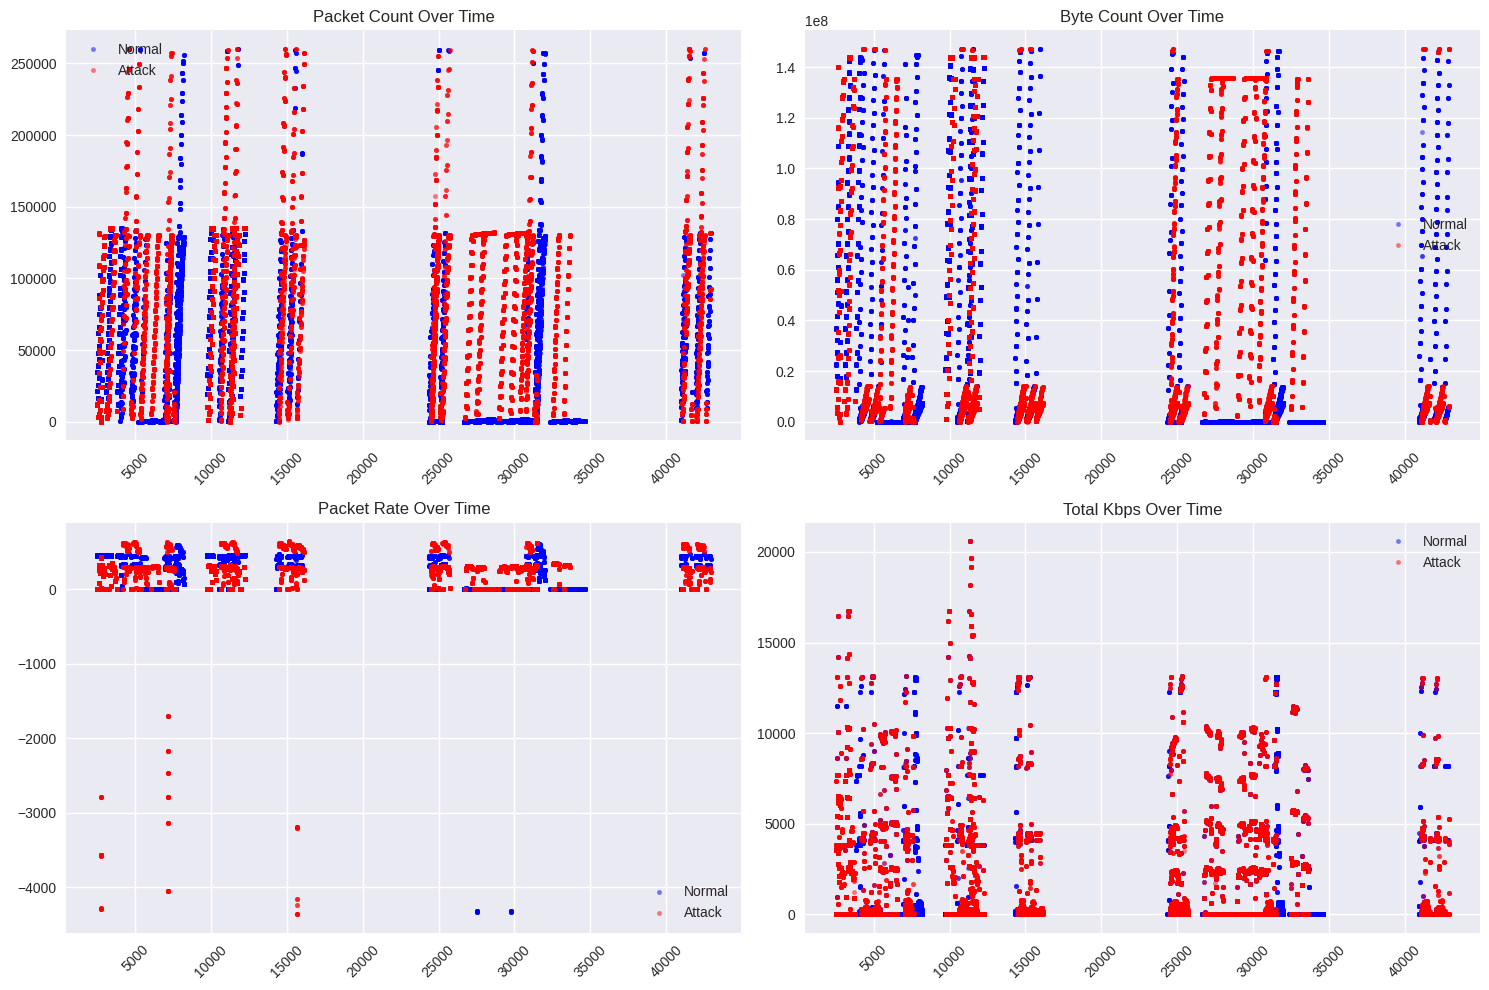

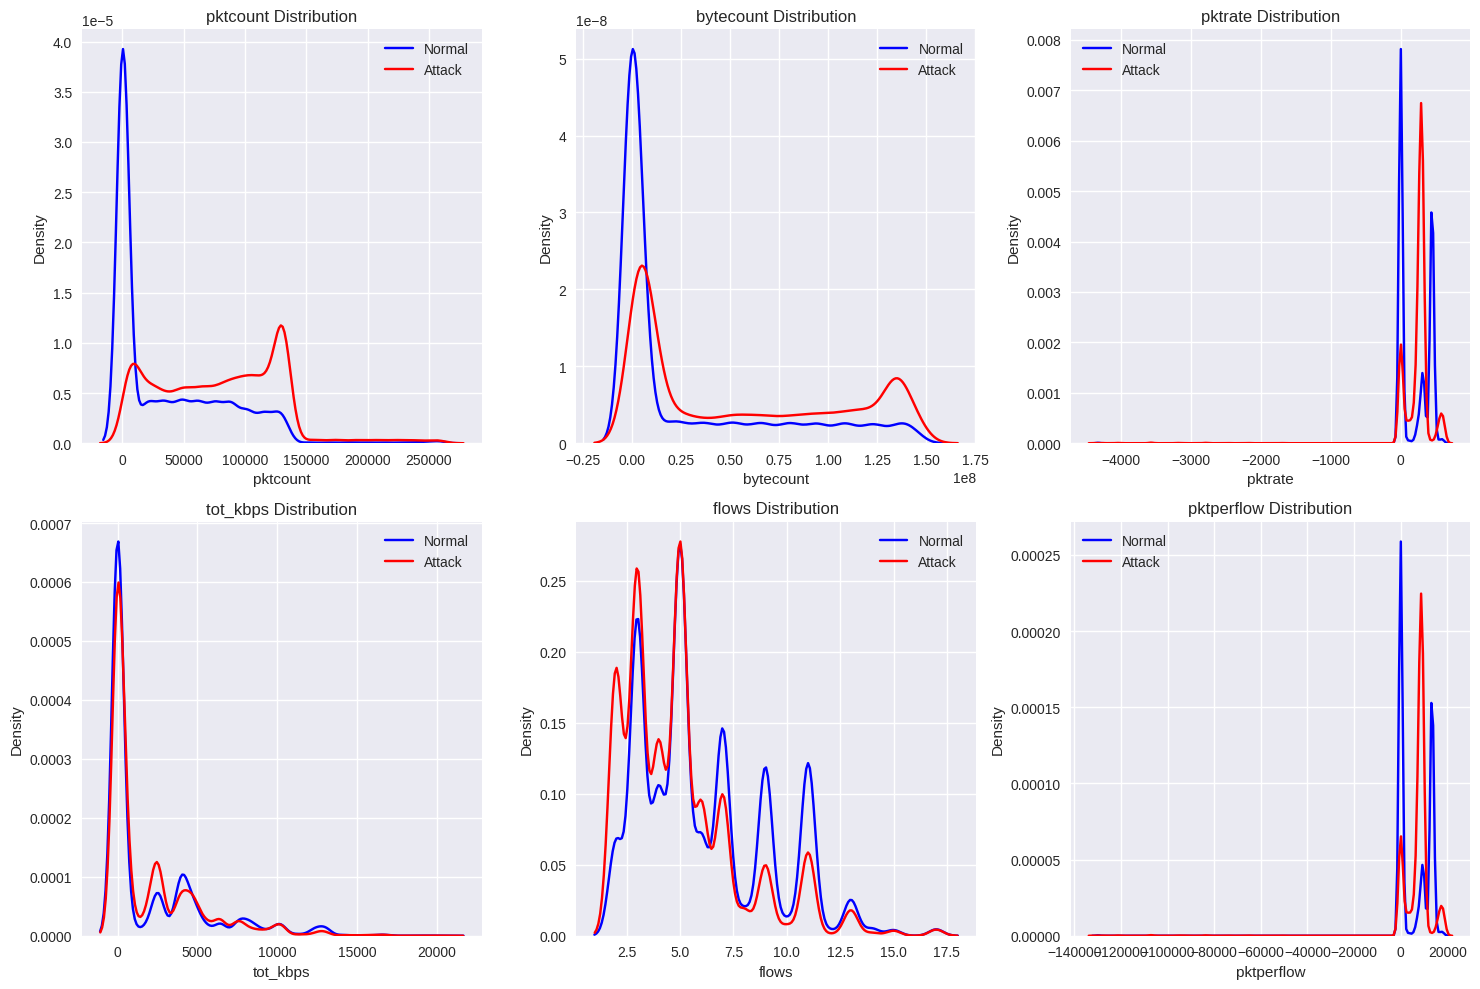

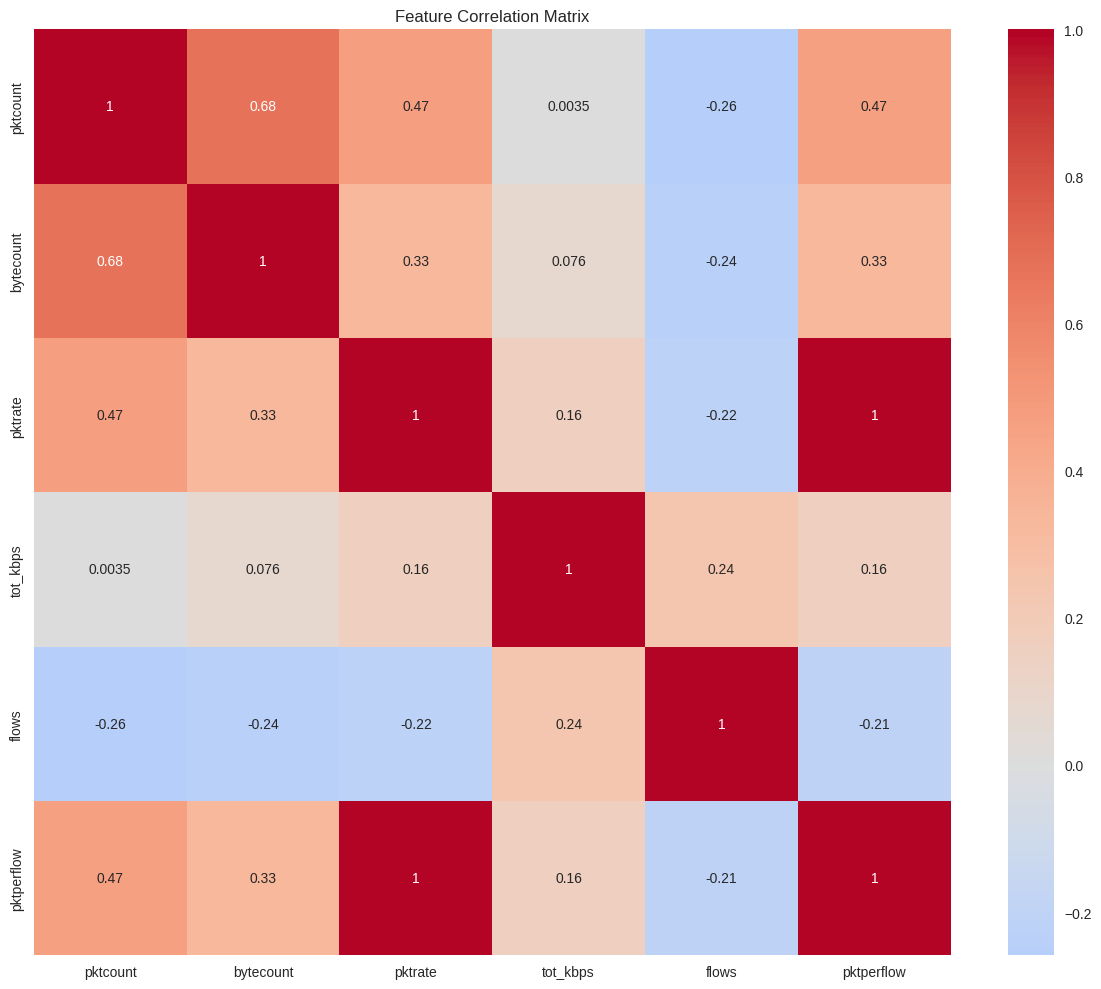

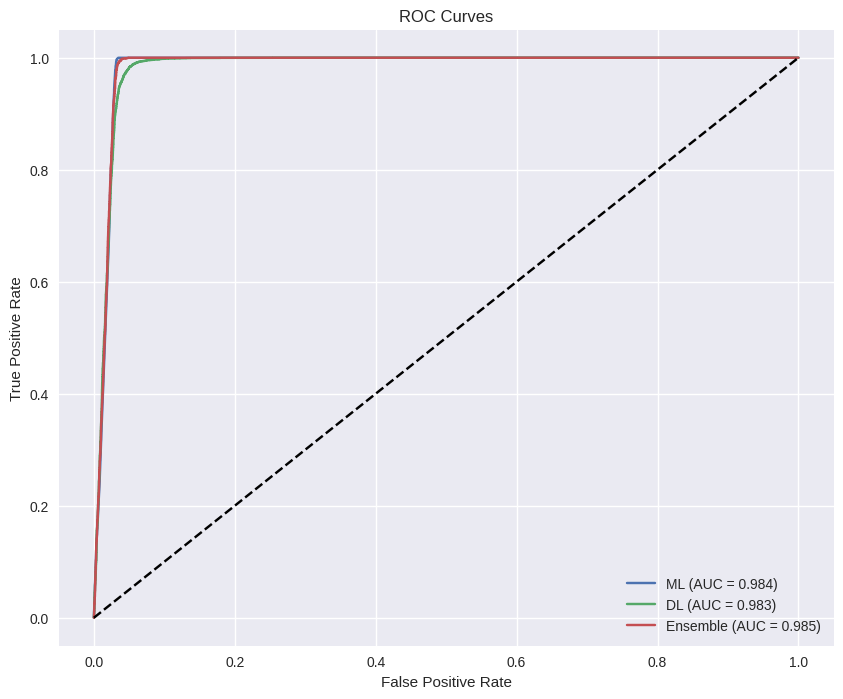

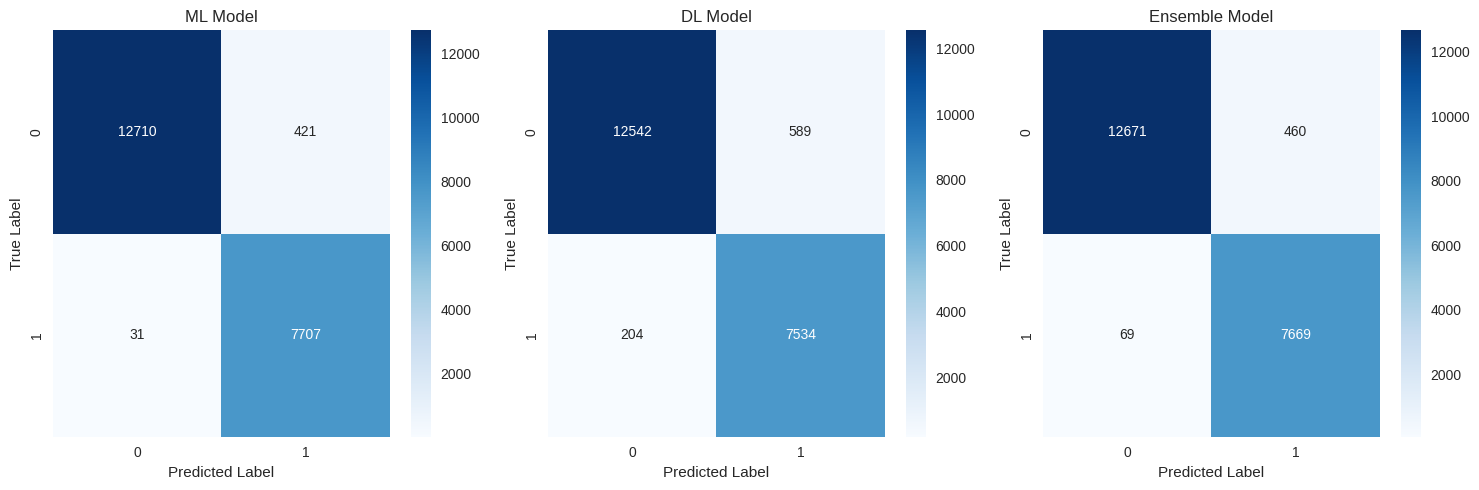

In [18]:
if __name__ == "__main__":
    main()